<a href="https://colab.research.google.com/github/RayenArbi/nike-adidas-/blob/main/Nike_Adidas_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nike vs Adidas Image Classification

This notebook uses **TensorFlow / Keras** with **ResNet50** transfer learning to classify images of Nike vs Adidas shoes.



ps:  Upload `archive.zip` to Colab and place it in `/content` or mount Google Drive and provide path.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-gpu
!pip install tensorflow_hub

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:

# OPTIONAL: Mount Google Drive if you want to save models/results there
# from google.colab import drive
# drive.mount('/content/drive')

# If you uploaded archive.zip to /content or /mnt/data, adjust paths below.
DATA_ZIP = "/content/archive (1).zip"  # adjust if needed in Colab (/content/archive.zip)
EXTRACT_DIR = "/content/archive (1)"   # change if you extract elsewhere
print("Set DATA_ZIP and EXTRACT_DIR as needed before running unzip/extract cell.")


Set DATA_ZIP and EXTRACT_DIR as needed before running unzip/extract cell.


In [ ]:
# Unzip dataset (if not already unzipped)
import os, zipfile
DATA_ZIP = "/content/archive (1).zip"
EXTRACT_DIR = "/content/archive (1)"
if not os.path.exists(EXTRACT_DIR) or not os.listdir(EXTRACT_DIR): # Check if directory exists and is not empty
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    if os.path.exists(DATA_ZIP):
        try:
            with zipfile.ZipFile(DATA_ZIP, 'r') as z:
                z.extractall(EXTRACT_DIR)
            print("Extracted archive.zip to", EXTRACT_DIR)
            # Verify extraction by listing contents
            for root, dirs, files in os.walk(EXTRACT_DIR):
                level = root.replace(EXTRACT_DIR, '').count(os.sep)
                indent = ' ' * 4 * (level)
                print(f'{indent}{os.path.basename(root)}/ ({len(dirs)} dirs, {len(files)} files)')
                if level < 2: # Limit depth of file listing
                    for f in files[:5]:
                        print(f'{indent}    {f}')
        except zipfile.BadZipFile:
            print(f"Error: {DATA_ZIP} is not a valid zip file.")
        except Exception as e:
            print(f"An error occurred during extraction: {e}")
    else:
        print("archive.zip not found at", DATA_ZIP, ". Please upload archive.zip to this location or adjust the DATA_ZIP path.")
else:
    print("Dataset directory already exists and is not empty at", EXTRACT_DIR)

Extracted archive.zip to /content/archive (1)
archive (1)/ (3 dirs, 1 files)
    labelnames.csv
    validation/ (2 dirs, 0 files)
        adidas/ (0 dirs, 27 files)
        nike/ (0 dirs, 28 files)
    train/ (2 dirs, 0 files)
        adidas/ (0 dirs, 230 files)
        nike/ (0 dirs, 230 files)
    test/ (2 dirs, 0 files)
        adidas/ (0 dirs, 30 files)
        nike/ (0 dirs, 30 files)


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import keras
import tensorflow_hub as hub
import numpy as np

## Expected folder structure

The model expects the dataset to be organized like:

```
dataset/
 ├── train/
 │    ├── nike/
 │    └── adidas/
 ├── val/
                                │    ├── nike/
 │    └── adidas/
 └── test/
      ├── nike/
      └── adidas/
```



If your dataset is a single folder with class subfolders (e.g. train & test not present), you can run this  code to split it.

In [ ]:
# Data preparation with ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = "/content/archive (1)"  # adjust if necessary

# Define the paths to the train, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Check if the directories exist
if not os.path.exists(train_dir) or not os.path.exists(val_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError(f"Couldn't find train, validation, or test folders under {base_dir}. Please arrange your data or adjust base_dir.")

# Setup ImageDataGenerator
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print("Classes:", train_generator.class_indices)

Found 460 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Classes: {'adidas': 0, 'nike': 1}


In [ ]:
import os

def count_images(directory):
    counts = {}
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(directory, split)
        print(f"\n📂 {split.upper()}:")
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            n_images = len(os.listdir(cls_path))
            counts[(split, cls)] = n_images
            print(f"{cls}: {n_images} images")
    return counts

counts = count_images("/content/archive (1)")



📂 TRAIN:
adidas: 230 images
nike: 230 images

📂 VALIDATION:
adidas: 27 images
nike: 28 images

📂 TEST:
adidas: 30 images
nike: 30 images


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2 # Changed from ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1️⃣DATA PREPARATION

In [ ]:
train_dir = "/content/archive (1)/train"
val_dir = "/content/archive (1)/validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)

Found 460 images belonging to 2 classes.
Found 55 images belonging to 2 classes.


# 2️⃣ MODEL BUILDING

In [ ]:
num_classes = 2  # Nike vs Adidas
# Changed from ResNet50
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # First, freeze base layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Adjusted learning rate for the first training phase
model.compile(optimizer=optimizers.Adam(learning_rate=5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3️⃣ TRAIN PHASE 1: FEATURE EXTRACTION

In [ ]:
EPOCHS = 15  # Increased epochs for first phase
checkpoint_path = "/content/mobilenetv2_shoes_best_stage1.keras" # Updated checkpoint path

callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True), # Increased patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1) # Increased patience
]

print("🔹 Training frozen MobileNetV2 base model...")
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks)


🔹 Training frozen MobileNetV2 base model...
Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6211 - loss: 1.2839
Epoch 1: val_accuracy improved from -inf to 0.76364, saving model to /content/mobilenetv2_shoes_best_stage1.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6214 - loss: 1.2837 - val_accuracy: 0.7636 - val_loss: 0.9783 - learning_rate: 5.0000e-04
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6966 - loss: 1.1720
Epoch 2: val_accuracy improved from 0.76364 to 0.78182, saving model to /content/mobilenetv2_shoes_best_stage1.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6977 - loss: 1.1696 - val_accuracy: 0.7818 - val_loss: 0.9570 - learning_rate: 5.0000e-04
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7775 - loss: 1.0006
Epoch 3: val_accuracy improved from 0.78182 to 0.81818, saving model to /content/mobilenetv2_shoes_best_stage1.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7781 - loss: 0.9985 

Evaluating the model before fine-tuning (after stage 1)

In [ ]:
print("🔹 Evaluating the model before fine-tuning (after stage 1)...")

# Load the model saved after the first training phase
model_stage1 = tf.keras.models.load_model("/content/mobilenetv2_shoes_best_stage1.keras")

# Assuming val_generator and test_generator are already defined from previous cells
# If not, you would need to redefine them here

print("🔹 Evaluating on validation data (after stage 1)...")
loss_stage1_val, acc_stage1_val = model_stage1.evaluate(val_generator)
print(f"✅ Validation Accuracy (after stage 1): {acc_stage1_val*100:.2f}%")

print("🔹 Evaluating on test data (after stage 1)...")
loss_stage1_test, acc_stage1_test = model_stage1.evaluate(test_generator)
print(f"✅ Test Accuracy (after stage 1): {acc_stage1_test*100:.2f}%")

🔹 Evaluating the model before fine-tuning (after stage 1)...
🔹 Evaluating on validation data (after stage 1)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8284 - loss: 0.8312
✅ Validation Accuracy (after stage 1): 83.64%
🔹 Evaluating on test data (after stage 1)...
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6615 - loss: 1.0194
✅ Test Accuracy (after stage 1): 73.33%


# 4️⃣ FINE-TUNING

In [ ]:
print("🔹 Fine-tuning the top MobileNetV2 layers...")
# Load best weights from stage 1 before fine-tuning
model.load_weights(checkpoint_path)

base_model.trainable = True
# Fine-tune more layers for potentially better accuracy
fine_tune_from = 100 # Adjust this value based on MobileNetV2 architecture (less than ~150 total layers)
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

# Adjusted learning rate for fine-tuning
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10 # Number of epochs for fine-tuning
total_epochs = EPOCHS + fine_tune_epochs

# Combine histories for plotting later if needed
history_combined = history.history

print(f"🔹 Starting fine-tuning from epoch {history.epoch[-1] + 1} for {fine_tune_epochs} epochs...")

callbacks_fine_tune = [
    ModelCheckpoint("/content/mobilenetv2_shoes_best_stage2.keras", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1)
]


history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1, # Start from the next epoch after stage 1
    callbacks=callbacks_fine_tune
)

# Combine the history objects
for key in history_fine.history.keys():
    history_combined[key] = history_combined[key] + history_fine.history[key]

🔹 Fine-tuning the top MobileNetV2 layers...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 126 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🔹 Starting fine-tuning from epoch 13 for 10 epochs...
Epoch 14/25
 9/15 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7517 - loss: 0.9918

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7510 - loss: 1.0065
Epoch 14: val_accuracy improved from -inf to 0.81818, saving model to /content/mobilenetv2_shoes_best_stage2.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.7511 - loss: 1.0081 - val_accuracy: 0.8182 - val_loss: 0.8106 - learning_rate: 1.0000e-05
Epoch 15/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7646 - loss: 0.9897
Epoch 15: val_accuracy did not improve from 0.81818
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7657 - loss: 0.9878 - val_accuracy: 0.8182 - val_loss: 0.8112 - learning_rate: 1.0000e-05
Epoch 16/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7591 - loss: 0.9578
Epoch 16: val_accuracy did not improve from 0.81818
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7594 - loss: 0.9590 - val_accuracy: 0.8182 - val_loss: 0.8142 - learning_rate: 1.0000e-05
Epoch 17/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8341 - loss: 0.8694
Epoch 17: val_accuracy impro

# 5️⃣ EVALUATION

In [ ]:
print("🔹 Evaluating on validation data after fine-tuning...")
loss, acc = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {acc*100:.2f}%")


# Also evaluate on the test set for a final performance metric
print("🔹 Evaluating on test data...")
test_dir = "/content/archive (1)/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1, # Use batch size 1 for prediction/evaluation
    class_mode='categorical',
    shuffle=False # Important for evaluation metrics
)
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_acc*100:.2f}%")



🔹 Evaluating on validation data after fine-tuning...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 820ms/step - accuracy: 0.8509 - loss: 0.8435
✅ Final Validation Accuracy: 85.45%
🔹 Evaluating on test data...
Found 60 images belonging to 2 classes.
 1/60 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 1.0000 - loss: 0.6023

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7077 - loss: 0.9384
✅ Final Test Accuracy: 75.00%


# 6️⃣ SAVE MODEL

In [ ]:
model.save('/content/mobilenetv2_shoes_final_finetuned.keras') # Changed filename and format
print("💾 Model saved as mobilenetv2_shoes_final_finetuned.keras")

💾 Model saved as mobilenetv2_shoes_final_finetuned.keras


Could not load best weights: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/resnet50_shoes_best.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
Classification Report:
              precision    recall  f1-score   support

      adidas       0.80      0.67      0.73        30
        nike       0.71      0.83      0.77        30

    accuracy                           0.75        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.76      0.75      0.75        60



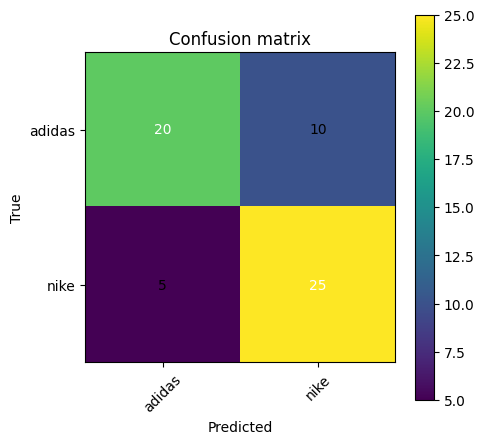

In [ ]:

# Evaluation on test set
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load best model if checkpoint exists
try:
    model.load_weights('/content/resnet50_shoes_best.h5')
    print('Loaded best weights.')
except Exception as e:
    print('Could not load best weights:', e)

# Predictions
test_steps = test_generator.samples
preds = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks(range(len(train_generator.class_indices)), list(train_generator.class_indices.keys()), rotation=45)
plt.yticks(range(len(train_generator.class_indices)), list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center', color='white' if val>cm.max()/2 else 'black')
plt.show()


some of the images prediction

Model loaded successfully!


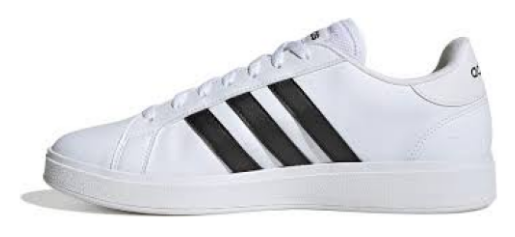

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 Prediction: adidas (96.57% confidence)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt

# Load the saved model
try:
    model = tf.keras.models.load_model('/content/mobilenetv2_shoes_final_finetuned.keras')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    # If model loading fails, you might need to run the previous cells to train and save it.
    model = None # Set model to None if loading fails

# Assuming train_generator was created in a previous cell and its class_indices are available
# If not, you might need to recreate a dummy generator or manually define classes
# Example of manually defining classes if train_generator is not available:
# class_labels = ['adidas', 'nike']

def predict_image(img_path, model, target_size=(224,224)):
    if model is None:
        print("Model is not loaded. Cannot make predictions.")
        return None, None

    if not os.path.exists(img_path):
        print(f"Error: Image not found at {img_path}")
        return None, None

    # Display the image
    img_display = image.load_img(img_path)
    plt.imshow(img_display)
    plt.axis('off') # Hide axes
    plt.show()

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)

    # Assuming train_generator.class_indices is available from a previous cell
    # If not, use the manually defined class_labels if you created them
    try:
        class_labels = list(train_generator.class_indices.keys())
    except NameError:
        print("Warning: train_generator not found. Using default class labels ['adidas', 'nike'].")
        class_labels = ['adidas', 'nike'] # Fallback if train_generator is not defined


    # Get the confidence score for the predicted class
    confidence = np.max(preds)
    predicted_class_index = np.argmax(preds)

    if predicted_class_index < len(class_labels):
        predicted_class = class_labels[predicted_class_index]
        print(f"🧠 Prediction: {predicted_class} ({confidence*100:.2f}% confidence)")
        return predicted_class, confidence
    else:
        print("Error: Predicted class index is out of bounds for class labels.")
        return None, None


# === Example Usage ===
# Set this to the path of the image you want to predict
IMAGE_PATH = "/content/add.png" # !! CHANGE THIS TO YOUR IMAGE PATH !!

if model is not None:
  predicted_class, confidence = predict_image(IMAGE_PATH, model)

Saving The model for the Streamlit app!!

In [ ]:
from google.colab import files
files.download("/content/mobilenetv2_shoes_final_finetuned.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("mobilenetv2_shoes_final_finetuned.keras", save_format="keras")
